In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import folium

## load dataset

Load traffic flow data of the selected nodes

In [15]:
time_index = pd.date_range(
    start=pd.to_datetime(f"2023-01-01 00:00"),
    end=pd.to_datetime(f"2023-12-31 23:55"),
    freq='5min'
)

In [3]:
node_sel = [405389, 422008, 422007, 405141]
raw_flow_sel = np.load('data/raw_flow_sel.npy')

In [13]:
sensor_meta_info_sel = pd.read_csv('data/sensor_meta_info_sel.csv')

Load incident data

In [10]:
incidents_sel = pd.read_csv('data/incidents_sel.csv')
incidents_sel['Start Time'] = pd.to_datetime(incidents_sel['Start Time'])


Screening for accidents with long duration

In [12]:
incidents_sel_filtered = incidents_sel.loc[
    (incidents_sel['Duration (mins)'] >= 100) & 
    (incidents_sel['type'].isin(['accident']))
]
incidents_sel_filtered = incidents_sel_filtered.sort_values(by='Duration (mins)', ascending=False)
incidents_sel_filtered

,Incident Id,Start Time,Duration (mins),Freeway,CA PM,Abs PM,Source,AREA,LOCATION,DESCRIPTION,type,nearest_node
3,21460782,2023-02-11 21:31:00,824,SR37-E,R11.5,0.3,CHP,Marin,Sr37 E / Us101 N Sr37 E Con,1179-Trfc Collision-1141 Enrt,accident,422008
16,22073784,2023-12-15 00:15:00,123,US101-N,19.676,460.2,CHP,Marin,Us101 N / S Novato Blvd Ofr,1179-Trfc Collision-1141 Enrt,accident,405141


## Local causal analysis

Consider the first incident in `incidents_sel_filtered`

In [19]:
cur_incident = incidents_sel_filtered.iloc[0]
start_time, duration = cur_incident['Start Time'], cur_incident['Duration (mins)']
end_time = start_time + pd.Timedelta(minutes=duration)

incident_name = cur_incident['DESCRIPTION']
incident_type = cur_incident['type']
node_id = cur_incident['nearest_node']
node_idx = node_sel.index(node_id)

print(f"Start Time: {start_time}, Duration: {duration}, Nearest Sensor Id: {node_id},\n"
      f"Type: {incident_type}, Description: {incident_name}, Location: Freeway {cur_incident['Freeway']}, Abs PM {cur_incident['Abs PM']}")
start_idx = np.where(time_index <= start_time)[0][-1]
end_idx = np.where(time_index < end_time)[0][-1]

Start Time: 2023-02-11 21:31:00, Duration: 824, Nearest Sensor Id: 422008,
Type: accident, Description: 1179-Trfc Collision-1141 Enrt, Location: Freeway SR37-E, Abs PM 0.3


### Visualization

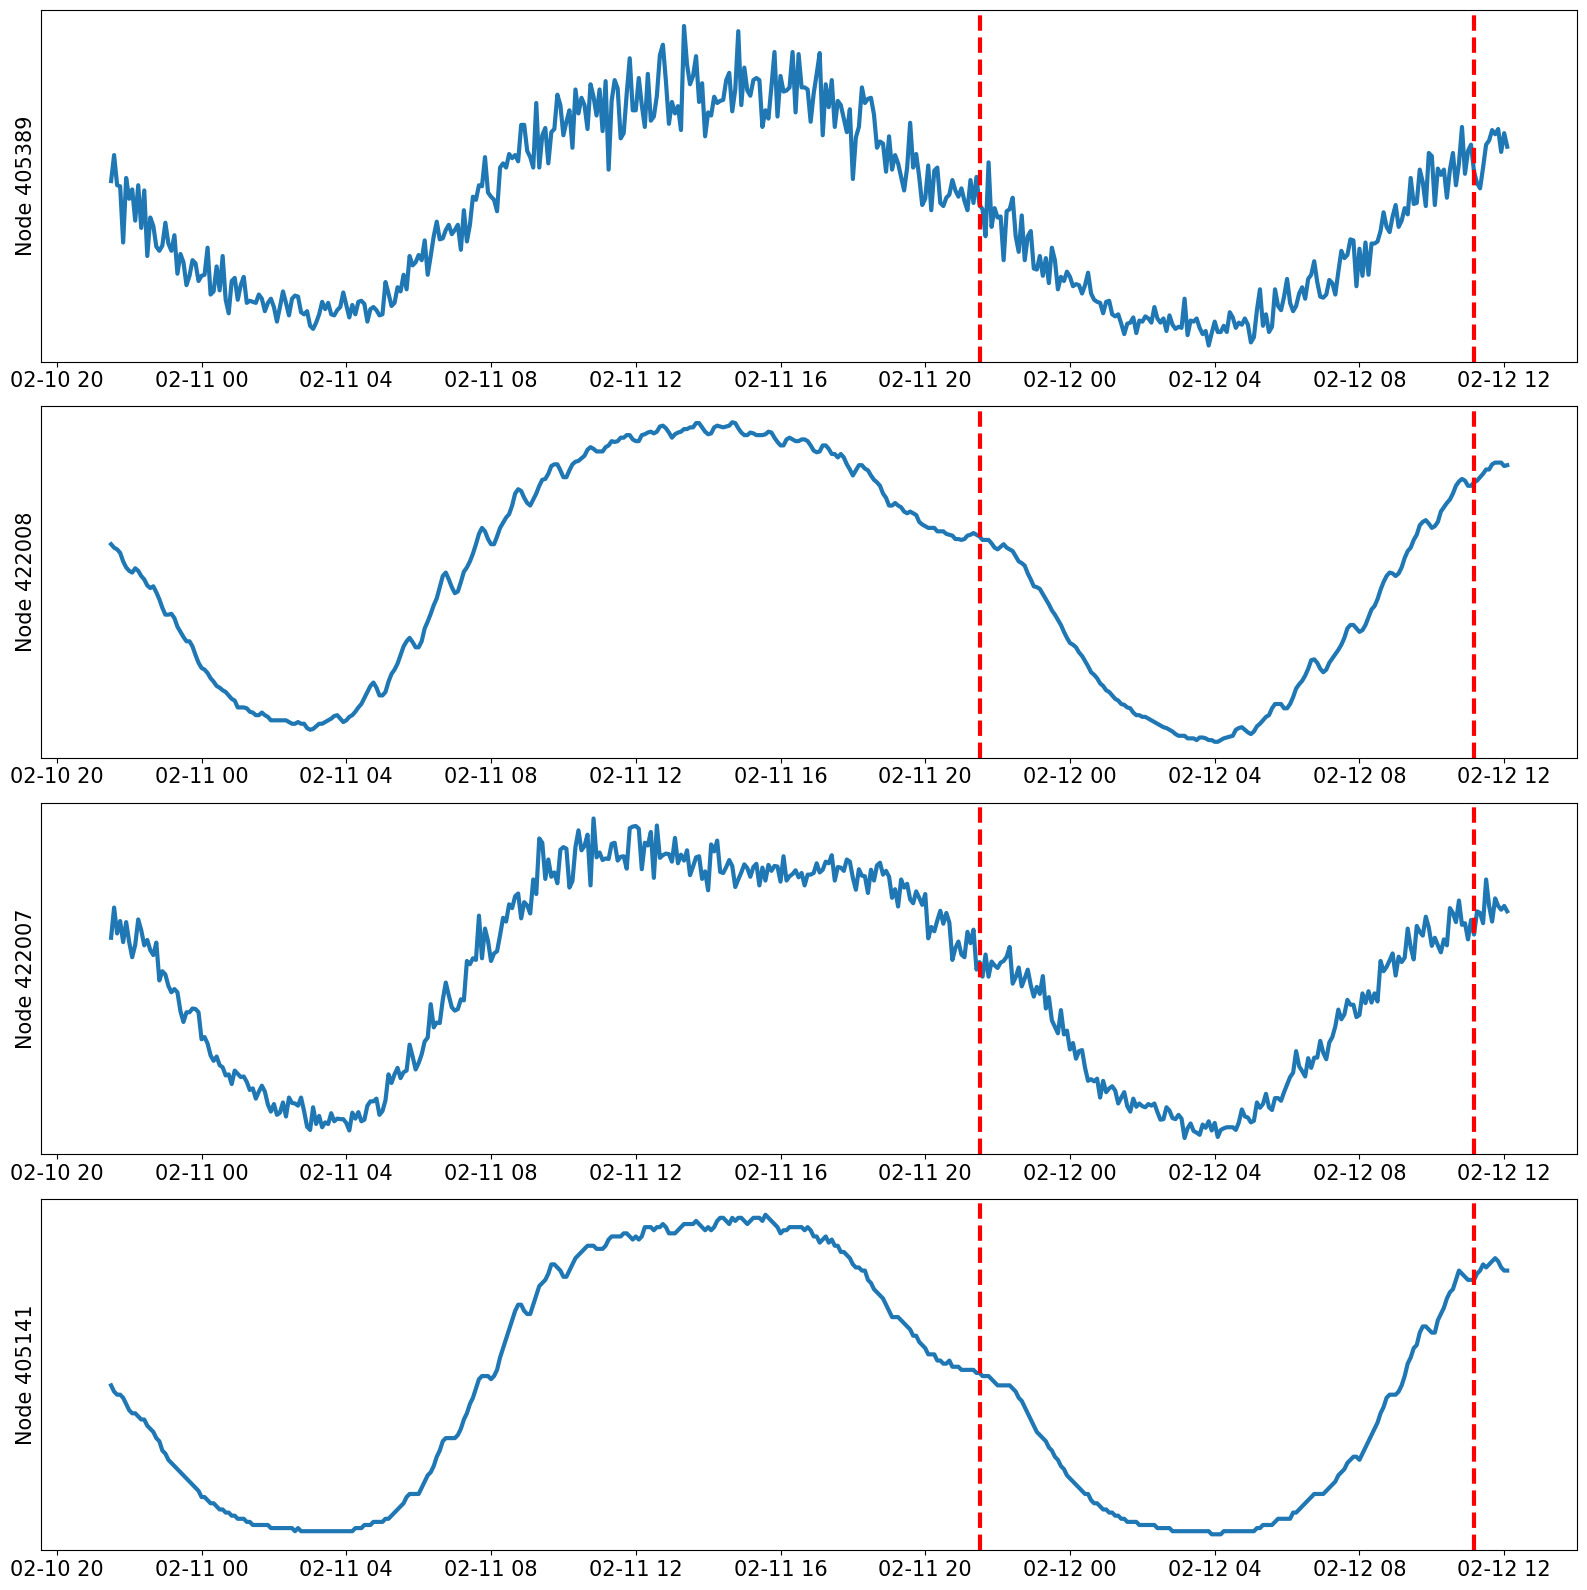

In [25]:
tick_label_size = 15
line_width = 3

# region plot time series of the selected nodes
pre_len, future_len = 12*24, 12*1
plot_start, plot_end = max(start_idx-pre_len, 0), min(end_idx + future_len, raw_flow_sel.shape[0] - 1)
cur_time_index = pd.Series(time_index).iloc[plot_start:plot_end]

fig, ax = plt.subplots(4, 1, figsize=(16, 4*4))
for i in range(4):
    ax[i].plot(cur_time_index, raw_flow_sel[plot_start:plot_end, i], linewidth=line_width)
    ax[i].axvline(cur_time_index.iloc[start_idx-plot_start], color='r', linestyle='--', linewidth=line_width)
    ax[i].axvline(cur_time_index.iloc[end_idx-plot_start], color='r', linestyle='--', linewidth=line_width)
    ax[i].tick_params(labelsize=tick_label_size)
    ax[i].set_ylabel(f"Node {node_sel[i]}", fontsize=tick_label_size)
    ax[i].set_yticks([])
fig.tight_layout()
plt.show()
# endregion

Plot the selected nodes in OpenStreet map

In [26]:
def plot_folium_node_with_marker(cur_node_geo_info, save_name='case_with_mark.html'):
    m = folium.Map(location=[cur_node_geo_info['Lat'].mean(), 
                             cur_node_geo_info['Lng'].mean()], 
                   zoom_start=14)

    # 添加节点的名字
    for index, row in cur_node_geo_info.iterrows():
        if np.isnan(row['Lat']) or np.isnan(row['Lng']):
            continue
        folium.Marker(
            location=[row['Lat'], row['Lng']],
            popup=f"{row['station_id']}\n{row['Type']}\n{row['Name']}"
        ).add_to(m)
    
    m.add_child(folium.LatLngPopup())
    # plot 
    m.save(save_name)
    return m

In [27]:
map = plot_folium_node_with_marker(sensor_meta_info_sel)
map

### PCMCI Analysis

In [30]:
# region utils functions
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS
from tigramite.independence_tests.gpdc import GPDC
import time

def data_process(x, var_names=None, normalize=True):
    # x (T, N)
    T, N = x.shape
    if normalize:
        mean, std = pp.weighted_avg_and_std(x, axis=0, weights=np.ones((T, N), dtype='int'))
        x = (x - mean) / (std + 1e-5)
    
    df = pp.DataFrame(x, var_names=var_names)
    return df

def run_single_PCMCI(cur_dataframe, cur_var_names, tau_max=10, pc_alpha=0.01, cond_test='GPDC',
                     save_dir=None, fig_name='PCMCI', print_time=True, show_plot=True,
                     **plot_kwargs):
    if cond_test == 'ParCorr':
        parcorr = ParCorr(significance='analytic')
    elif cond_test == 'RobustParCorr':
        parcorr = RobustParCorr(significance='analytic')
    elif cond_test == 'ParCorrWLS':
        parcorr = ParCorrWLS(significance='analytic')
    elif cond_test == 'GPDC':
        parcorr = GPDC(significance='analytic')
    else:
        raise ValueError("cond_test should be 'ParCorr' or 'RobustParCorr'")
    pcmci = PCMCI(dataframe=cur_dataframe, cond_ind_test=parcorr, verbosity=0)

    if print_time:
        print(f"-------------> Time Series len {cur_dataframe.T[0]}")
        start_time = time.time()
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)
    q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')
    graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=pc_alpha, 
                tau_min=0, tau_max=tau_max, link_assumptions=None)
    results['graph'] = graph

    if print_time:
        print(f"-------------> Training Time: {(time.time() - start_time)/60:.3f} min\n")

    # plot
    save_name = None
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_name = save_dir + '/' + fig_name + '.png'
    tp.plot_graph(
        save_name=save_name,
        val_matrix=results['val_matrix'],
        graph=results['graph'],
        var_names=cur_var_names,
        link_colorbar_label='cross-MCI (edges)',
        node_colorbar_label='auto-MCI (nodes)',
        **plot_kwargs
        # node_size=args.node_size, arrow_linewidth=args.arrow_linewidth
    )
    if not show_plot:
        plt.close()
    return results
# endregion

In [32]:
# specify data used in local causal analysis
before_range = (start_idx - 12*24, start_idx)
after_range = (start_idx, end_idx + 12*0)

before_data = raw_flow_sel[before_range[0]:before_range[1]]
after_data = raw_flow_sel[after_range[0]:after_range[1]]

In [33]:
def norm_pos(node_pos, fig_size=(16, 9)):
    x, y = node_pos['x'], node_pos['y']
    x, y = np.array(x), np.array(y)
    x = (x - x.min()) / (x.max() - x.min()) * fig_size[0]
    y = (y - y.min()) / (y.max() - y.min()) * fig_size[1]
    return {
        'x': x, 'y': y
    }

# region causal plot params
fig_size, node_size = (4, 3.5), 1

node_name = [r'X$^1$', r'X$^3$', r'X$^4$', r'X$^2$']
pos = {'X1': (0, 5), 'X3': (1.5, 3), 'X4': (3, 4.5), 'X2': (1, 1)}
node_tp_pos = norm_pos({
    'x': [lng for _, (lng, lat) in pos.items()],
    'y': [lat for _, (lng, lat) in pos.items()]
}, fig_size)
# endregion

Pre-incident Graph

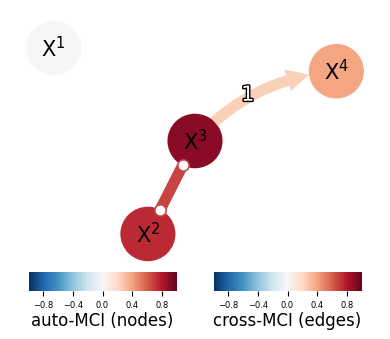

In [34]:
pp_data_before = data_process(before_data, var_names=node_name)

fig, ax = plt.subplots(figsize=fig_size)
causal_ret_before =run_single_PCMCI(
    pp_data_before, node_name, tau_max=1, pc_alpha=0.01, cond_test='ParCorr',
    print_time=False, show_plot=True, node_pos=node_tp_pos, 
    figsize=fig_size, node_size=node_size, fig_ax=(fig, ax),
    node_aspect=0.76, node_label_size=15, label_fontsize=12, link_label_fontsize=15
)
fig.tight_layout()
plt.show()

Post-incident Graph

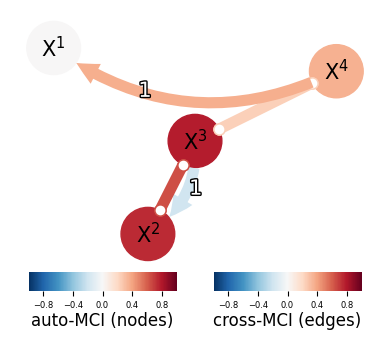

In [36]:
pp_data_after = data_process(after_data, var_names=node_name)

fig, ax = plt.subplots(figsize=fig_size)
causal_ret_after =run_single_PCMCI(
    pp_data_after, node_name, tau_max=1, pc_alpha=0.04, cond_test='ParCorr',
    print_time=False, show_plot=True, node_pos=node_tp_pos, 
    figsize=fig_size, node_size=node_size, fig_ax=(fig, ax),
    node_aspect=0.76, node_label_size=15, label_fontsize=12, link_label_fontsize=15, curved_radius=0.3
)
fig.tight_layout()
plt.show()